In [1]:
import yellowcab as yc
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx
import seaborn as sns
import geopandas as gpd
sns.set(style="darkgrid")
%matplotlib inline

In [2]:
taxi_zones_geojson = yc.io.read_all_files("geojson")
taxi_zones_geojson

,shape_area,objectid,shape_leng,location_id,zone,borough,geometry
0,0.0007823067885,1,0.116357453189,1,Newark Airport,EWR,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ..."
1,0.00486634037837,2,0.43346966679,2,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,0.000314414156821,3,0.0843411059012,3,Allerton/Pelham Gardens,Bronx,"MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ..."
3,0.000111871946192,4,0.0435665270921,4,Alphabet City,Manhattan,"MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ..."
4,0.000497957489363,5,0.0921464898574,5,Arden Heights,Staten Island,"MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ..."
...,...,...,...,...,...,...,...
258,0.000168611097013,256,0.0679149669603,256,Williamsburg (South Side),Brooklyn,"MULTIPOLYGON (((-73.95834 40.71331, -73.95681 ..."
259,0.000394552487366,259,0.126750305191,259,Woodlawn/Wakefield,Bronx,"MULTIPOLYGON (((-73.85107 40.91037, -73.85207 ..."
260,0.000422345326907,260,0.133514154636,260,Woodside,Queens,"MULTIPOLYGON (((-73.90175 40.76078, -73.90147 ..."
261,0.0000343423231652,261,0.0271204563616,261,World Trade Center,Manhattan,"MULTIPOLYGON (((-74.01333 40.70503, -74.01327 ..."


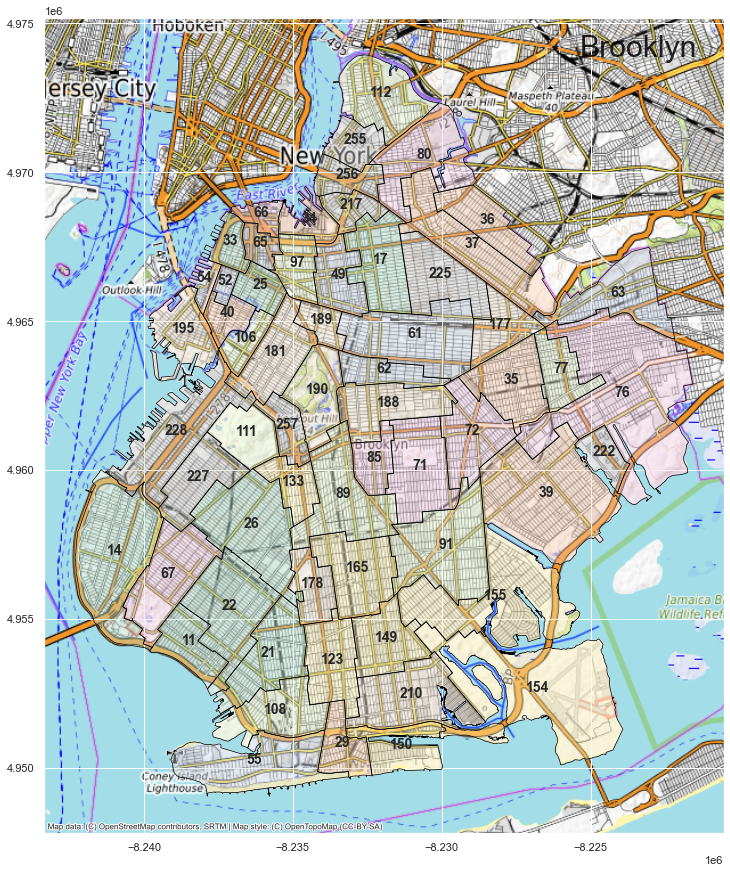

In [3]:
ax = yc.model.create_map(taxi_zones_geojson, "Brooklyn", "svg")

In [ ]:
def create_map(gdf, filter_borough="Brooklyn"):
    #filter
    gdf_filtered = gdf.to_crs(3857)[gdf['borough'] == filter_borough]

    # Set boundaries etc.
    gdf_filtered["area"] = gdf_filtered.area
    gdf_filtered['boundary'] = gdf_filtered.boundary
    gdf_filtered['centroid'] = gdf_filtered.centroid

    # Create plot
    fig = plt.figure(1, figsize=(15, 15))
    ax = fig.add_subplot()
    gdf_filtered.apply(
        lambda x: ax.annotate(text=x["location_id"], xy=x.geometry.centroid.coords[0], ha='center', fontsize=14, weight='bold'),
        axis=1)
    gdf_filtered.boundary.plot(ax=ax, color='Black', linewidth=.4)
    gdf_filtered.plot(ax=ax, cmap='Pastel2', figsize=(12, 12), alpha=0.4)
    ctx.add_basemap(ax, source=ctx.providers.OpenTopoMap)
    ax.text(
        0.875, 0.98, 'Brooklyn', transform=ax.transAxes,
        fontsize=30, color='black', alpha=0.85,
        ha='center', va='top', rotation='0'
    )
#    dir = "../../data/output/maps/"
#    fig.savefig(dir + "map_of_" + filter_borough + ".png")
    return fig, gdf_filtered

In [ ]:
trip_data = yc.io.read_all_files("parquet")

In [ ]:
trip_data_fil = yc.io.filter_borough(trip_data)

In [ ]:
trip_data_fil

In [ ]:
def add_location(df, start_location="PULocationID", end_location="DOLocationID", NaN=False):
    gdf = yc.io.read_all_files('geojson')
    taxi_zones_csv = yc.io.read_all_files('csv')
    # gdf = gpd.GeoDataFrame.from_features(taxi_zones_geojson["features"])

    geo_data = pd.DataFrame()
    geo_data["longitude"] = gdf.centroid.x
    geo_data["latitude"] = gdf.centroid.y

    if(not NaN):
        # total range of location_id is 1 - 265
        # there is no geo data for the locations 264 and 265
        df = df[(df["PULocationID"] < 264) & (df["DOLocationID"] < 264)]

        print("Trips with location_id above 263 were dropped, since there is no matching geo data.")

    df = pd.merge(df, geo_data, left_on="PULocationID", right_index=True, how="left", sort=False).rename(columns={"longitude":"start_location_long", "latitude":"start_location_lat"})
    df = pd.merge(df, geo_data, left_on="DOLocationID", right_index=True, how="left", sort=False).rename(columns={"longitude":"end_location_long", "latitude":"end_location_lat"})
    
    # Zone & service zone needed? Could be dropped
    csv = taxi_zones_csv.rename({"LocationID": 'PULocationID', "Borough": "PUBorough", "service_zone":"PUService_zone", "Zone":"PUZone"}, axis=1)
    df = pd.merge(df, csv, left_on="PULocationID", right_index=True, how="left", sort=False).drop(columns="PULocationID_y").rename(columns={"PULocationID_x":"PULocationID"})
    csv = taxi_zones_csv.rename({"LocationID": 'DOLocationID', "Borough": "DOBorough"}, axis=1)
    df = pd.merge(df, csv[{"DOLocationID", "DOBorough"}], left_on="DOLocationID", right_index=True, how="left", sort=False)
    #.drop(columns="DOLocationID_y").rename(columns={"DOLocationID_x":"DOLocationID"})

    
    return df

In [ ]:
add_location(trip_data_fil)

In [ ]:
taxi_zones_csv = yc.io.read_all_files('csv')
csv = taxi_zones_csv.rename({"LocationID": 'PULocationID', "Borough": "PUBorough"}, axis=1)
csv = taxi_zones_csv.rename({"LocationID": 'DOLocationID', "PUBorough": "DOBorough"}, axis=1)
csv